# Create and Run a Local RAG Pipeline From Scratch
The goal here is to build a RAG pipeline from scratch so that we can get generative answers on our custom documents. There are existing frameworks to build from like llamaindex and langchain, but in this session we will build it out from scratch to learn ourselves and get a better understanding of RAG.
## What is RAG?
Retrieval Augmented Generation (RAG) is a way we can improve the outputs of an LLM by grounding it in relevant, factual information. There are three components to RAG:
1. Retrieval: Based on the user's input prompt, search an existing database and find the most relevant knowledge sources.
2. Augmentation: Augment the user's prompt with snippets of that relevant data from the retrieved sources.
3. Generation: Use LLMs to provide an answer using the augmented prompt.

In short, we are `CTRL+F`'ing across a huge database and then using whatever relevant info we find to generate a useful answer in natural language that may feel more right to the user than what is explicitly stated in the knowledge source

## Why RAG?
Like mentioned before, it improves the LLM in two significant ways:
1. Reduces hallucination by grounding the model in factual information
2. Provides knowledge of custom, never-before-seen data to the model so it can generate more relevant answers.

## What can RAG be used for?
1. Customer support Q&A
2. Email Chain Analysis
3. Company internal documentation chat (onboarding, HR, employee policy, inside sales, etc.)
4. Textbook Q&A - for students

The common things is to take your relevant documents to a query and use your LLM to process them. **LLM is like a calculator for words.**

## Why should we run this locally?
ChatGPT is already good enough right? Why would we run it here (besides fun)?

1. Privacy: All of the documentation we use on a local RAG pipeline remains on our system and not get sent up to the big data companies. *Note there are ways to get around this with using larger models like Mistral that don't collect our information for training but we are still putting information up in the cloud which can be risky*. 
2. Speed: Need to wait for an API to run and you need access to the internet.
3. Cost: If you own your own hardware, the cost is already paid for.
4. No vendor lock-in. If OpenAI, Anthropic, Google, etc. decide to shut down API or change their processes, we have no risk of losing our functionality.

## What we're going to build
We're going to build a NutriChat to "chat with a nutrition textbook".
Specifically:
1. Open a PDF document
2. Format all of the PDF textbook (chunk it) ready for an embedding model.
3. Embed all of the chunks of the text and turn them into numerical representations (embedding) which can be stored for later.
4. Build a retrieval system that uses vector search (semantic search) to find relevant chunks based on the user query.
5. Augment the prompt to incorporate the retrieved pieces of text.
6. Generate an answer to the original propmpt based on the passages of the textbook using an LLM.

**ALL LOCALLY**
1. Steps 1-3 document preprocessing and indexing
2. Steps 4-6 search & answer

## 1. Document preprocessing and index
Ingredients:
- PDF document of choice (could be any specific document, clump of documents, etc.)
- Embedding model of choice

1. Import PDF Document
2. Process text to spilt into chunks (look at a few ways to process our PDF)
3. Embed text chunks using our embedding model
4. Store embeddings to file for later use

### 1.1 Import PDF Document

In [46]:
import os
import requests

# Get PDF document path
# pdf_path = "Alro-Metals-Guide.pdf"
pdf_path = "human-nutrition-text.pdf"

# Download
if not os.path.exists(pdf_path):
    print("[INFO] FILE doesn't exist, downloading...")

    url = "https://www.alro.com/Resources/WebResources/AlroCom/MetalsGuideCatalog/PDFs/MetalsGuide-May2020.pdf"

    file_name = pdf_path

    response = requests.get(url)

    if response.status_code == 200:
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {file_name}")
    else:
        print(f"[INFO] The file failed to download. Status code: {response.status_code}")

else:
    print(f"File {pdf_path} already exists.")


File human-nutrition-text.pdf already exists.


## 1.2 Process Text to Split into Chunks
We've got a PDF, now let's open it and "chunk" it up!

In [47]:
import fitz # requires !pip install PyMuPDF (fitz is a legacy name)
from tqdm.auto import tqdm 

def text_formatter(text: str) -> str:
    "Performs minor formatting on text."
    cleaned_text = text.replace("\n", " ").strip()

    # Potentially more text formatting functions can go here if needed
    return cleaned_text

def open_and_read_pdf(pdf_path:str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_text = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_text.append({"page_number": page_number - 41,
                               "page_char_count": len(text),
                               "page_word_count": len(text.split(" ")),
                               "page_sentence_count_raw": len(text.split(". ")),
                               "page_token_count": len(text) / 4, # 1 token is ~ 4 characters in english
                               "text": text
                               })
    return pages_and_text
pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)

0it [00:00, ?it/s]

In [48]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': 633,
  'page_char_count': 913,
  'page_word_count': 208,
  'page_sentence_count_raw': 17,
  'page_token_count': 228.25,
  'text': 'Foods  Serving Phosphorus  (mg)  Percent Daily Value  1000  Salmon  3 oz.  315  32  Yogurt, nonfat  8 oz.  306  31  Turkey, light meat  3 oz.  217  22  Chicken, light meat  3 oz.  135  14  Beef  3 oz.  179  18  Lentils*  ½ c.  178  18  Almonds*  1 oz.  136  14  Mozzarella  1 oz.  131  13  Peanuts*  1 oz.  108  11  Whole wheat bread  1 slice  68  7  Egg  1 large  86  9  Carbonated cola  drink  12 oz.  41  4  Bread, enriched  1 slice  25  3  Micronutrient Information Center: Phosphorus. Oregon State  University, Linus Pauling Institute. http://lpi.oregonstate.edu/mic/ minerals/phosphorus. Updated in July 2013. Accessed October 22,  2017.  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.  These activities are  available in the we

In [49]:
import pandas as pd
df = pd.DataFrame(pages_and_texts)
df.head()
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


Why do we care about token count?
1. Embedding models don't deal with infinite tokens
2. LLMs don't deal with infinite tokens. Even if they did, we have the lost-in-the-middle problem.
3. Tokens cost money if we are running APIs for costed models.
For example, an embedding model may have a token limit (max sequence length) of 384. As for LLMs, they can't accept unlimited tokens in their context window.

### Further Text processing (splitting  pages into sentences)
Two ways to do this:
1. We've done this by splitting on `". "`, which may not be as robust.
2. We can do this with an NLP library such as spaCy and nltk.

In [50]:
from spacy.lang.en import English
nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This is a second sentence. How about a third one?")
assert len(list(doc.sents)) == 3
list(doc.sents)

[This is a sentence., This is a second sentence., How about a third one?]

In [51]:
random.sample(pages_and_texts, k=1)

[{'page_number': 949,
  'page_char_count': 385,
  'page_word_count': 63,
  'page_sentence_count_raw': 3,
  'page_token_count': 96.25,
  'text': 'An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=496    An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=496  The Benefits of Physical Activity  |  949'}]

In [52]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (the default type is a spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [53]:
random.sample(pages_and_texts, k=1)
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


### Chunking our sentences together

The concept of splitting larger pieces of text into smaller ones is often referred to as text splitting or chunking.
There is no 100% correct way to do it, this is an active area of research.
We'll keep it simple and split it into groups of 10 sentences. You could try 5, 7, 8. You can do number of characters instead of sentences. You can do overlapping, etc. 

LangChain is a great package for us to do this with, but we will do it with just pure python for now.

Why we do this:
1. So our texts are easier to filter (smaller groups of text, easier to inspect than large)
2. So our text chunks can fit into our embedding model token size (e.g., 384 tokens)
3. So our context passed to LLM is specific and focused, and within the token input limit.

In [54]:
# Define split size to turn groups of sentecnes into chunks
num_sentence_chunk_size = 10

# Create function to split lists of texts recursively into chunk size
# e.g., list of 20 - > two lists of 10. ([20]-> [10, 10], [25] -> [10, 10, 5])
def split_list(input_list: list[str], slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [55]:
# Loop through our pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(item["sentences"])
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [56]:
random.sample(pages_and_texts, k=1)

[{'page_number': 204,
  'page_char_count': 1831,
  'page_word_count': 303,
  'page_sentence_count_raw': 15,
  'page_token_count': 457.75,
  'text': 'whole-grain foods, fish, poultry, and nuts are emphasized while red  meats, sweets, and sugar-containing beverages are mostly avoided.  In this study, people on the low-sodium (1500 milligrams per day)  DASH diet had mean systolic blood pressures that were 7.1 mmHg  lower than people without hypertension not on the DASH diet.  The effect on blood pressure was greatest in participants with  hypertension at the beginning of the study who followed the DASH  diet. Their systolic blood pressures were, on average, 11.5 mmHg  lower than participants with hypertension on the control diet.6  Following the DASH diet not only reduces sodium intake, but  also increases potassium, calcium, and magnesium intake. All of  these electrolytes have a positive effect on blood pressure, although  the mechanisms by which they reduce blood pressure are largely  

In [57]:
df = pd.DataFrame(pages_and_texts)
# df.head()
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32,1.53
std,348.86,560.38,95.83,6.55,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00,1.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00,1.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00,2.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00,3.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own embedding (numerical representation).

This will give us a good level of granularity when doing the retrieval.

In [58]:
import re

# split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any capital letter.

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token ~4chars

        pages_and_chunks.append(chunk_dict)
len(pages_and_chunks)


  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [59]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 503,
  'sentence_chunk': 'National Heart, Lung, and Blood Institute.1998, 51S–210S. http://www.ncbi.nlm.nih.gov/ books/NBK2003/. Accessed September 22, 2017. Dietary, Behavioral, and Physical Activity Recommendations for Weight Management | 503',
  'chunk_char_count': 218,
  'chunk_word_count': 24,
  'chunk_token_count': 54.5}]

In [60]:
# pages_and_chunks
df = pd.DataFrame(pages_and_chunks)
# df.head()
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.10,112.74,183.52
std,347.79,447.51,71.24,111.88
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,745.00,115.00,186.25
75%,890.00,1118.00,173.00,279.50
max,1166.00,1830.00,297.00,457.50


In [61]:
# percentage of chunks that will get cut by some amount of tokens when embedding
max_token_size_embedding_model = 384
len(df[df["chunk_token_count"]>384])/len(df) * 100

2.5501899077590884

Maybe some of our chunks are going to have some small token counts that clearly won't add a lot of value to the model.

These would be the ones that were cut off when chunking in 10 sentences at the end, e.g., a text cluster that had 11 sentences
will produce a chunk that has only 1 sentence. 

We don't want to waste processing power on such a small chunk, so let's filter those out

In [62]:
# Sanity check to make sure the token limit we chose isn't filtering out useful data
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f"Chunk token count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

Chunk token count: 23.0 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=301 The Atom | 471
Chunk token count: 19.25 | Text: The function of the anticoagulant drug warfarin is 544 | Fat-Soluble Vitamins
Chunk token count: 10.5 | Text: 420 | Proteins, Diet, and Personal Choices
Chunk token count: 16.5 | Text: Table 4.6 Sweeteners Carbohydrates and Personal Diet Choices | 281
Chunk token count: 14.75 | Text: Folate is also found in legumes, liver, and Pregnancy | 787


In [63]:
# Actually filter out the low token chunks
pages_and_chunks_over_min_token_length = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
random.sample(pages_and_chunks_over_min_token_length, k=3)

[{'page_number': 1123,
  'sentence_chunk': 'and about food that they eat. Anorexia results in extreme nutrient inadequacy and eventually to organ malfunction. Anorexia is relatively rare—the National Institute of Mental Health (NIMH) reports that 0.9 percent of females and 0.3 percent of males will have anorexia at some point in their lifetime, but it is an extreme example of how an unbalanced diet can affect health.2 Anorexia frequently manifests during adolescence and it has the highest rate of mortality of all mental illnesses. People with anorexia consume, on average, fewer than 1,000 kilocalories per day and exercise excessively. They are in a tremendous caloric imbalance. Moreover, some may participate in binge eating, self-induced vomiting, and purging with laxatives or enemas. The very first time a person starves him- or herself may trigger the onset of anorexia. The exact causes of anorexia are not completely known, but many things contribute to its development including econo

## 1.3 Embed text chunks using our embedding model
Embeddings are a broad but powerful context.

We humans understand text while computers understand numbers. 

Therefore, we want to turn in our text chunks into representative numbers.

Embeddings: A useful numerical representation of words.

The best part of embeddings is that they are a *learned* representation.

For a great resource, see here: https://vickiboykis.com/what_are_embeddings/

In [64]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cuda")

# Create a list of sentences
sentences = ["The sentence transformer library provides an easy way to create embeddings.",
             "Sentences can be embedded one by one or in a list.",
             "I like horses!"]

# Sentences are encoded/embedded by calling model.encode

embeddings = embedding_model.encode(sentences)
embedding_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embedding_dict.items():
    print(f'Sentence: {sentence}')
    print(f"Embedding: {embedding}")

c:\Users\georg\anaconda3\envs\simple-local-rag\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The sentence transformer library provides an easy way to create embeddings.
Embedding: [-3.44285481e-02  2.95328666e-02 -2.33643260e-02  5.57257198e-02
 -2.19098367e-02 -6.47059968e-03  1.02849798e-02 -6.57803714e-02
  2.29718406e-02 -2.61120833e-02  3.80420983e-02  5.61402552e-02
 -3.68746333e-02  1.52787464e-02  4.37020995e-02 -5.19723818e-02
  4.89479043e-02  3.58104892e-03 -1.29750622e-02  3.54383164e-03
  4.23261896e-02  3.52606475e-02  2.49402039e-02  2.99177226e-02
 -1.99381579e-02 -2.39752550e-02 -3.33370687e-03 -4.30450104e-02
  5.72014228e-02 -1.32517749e-02 -3.54477689e-02 -1.13935769e-02
  5.55561371e-02  3.61096137e-03  8.88527381e-07  1.14027262e-02
 -3.82229760e-02 -2.43542343e-03  1.51313916e-02 -1.32580055e-04
  5.00659533e-02 -5.50876744e-02  1.73444375e-02  5.00958823e-02
 -3.75959501e-02 -1.04463696e-02  5.08322828e-02  1.24860900e-02
  8.67376775e-02  4.64142784e-02 -2.10690200e-02 -3.90251763e-02
  1.99694163e-03 -1.42345838e-02 -1.86794903e-02  2.826696

In [65]:
embeddings[0].shape

(768,)

In [66]:
%%time

embedding_model.to("cuda")
for item in tqdm(pages_and_chunks_over_min_token_length):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: total: 6min 20s
Wall time: 1min 4s


In [67]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_length]
text_chunks[419]

CPU times: total: 0 ns
Wall time: 1 ms


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [68]:
%%time

# Embed all texts in batches instead since GPUs can parallel process!
text_chunk_embeddings = embedding_model.encode(text_chunks,batch_size=16,convert_to_tensor=True)

CPU times: total: 2min 28s
Wall time: 46.7 s


## 1.4 Store embeddings to file for later use

In [69]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_length)
text_chunks_and_embeddings_df.head()
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [70]:
# Check that we can saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242601e-02 9.02281627e-02 -5.09549398e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156307e-02 5.92139363e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801954e-02 3.39813828e-02 -2.06426587e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566911e-02 3.81274968e-02 -8.46854039e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264382e-02 -8.49764328e-03 9.57158767e-...


CSVs aren't the most effective way to store this information.

A slightly better way to do this is to store them in torch.tensor. 
This will work even for ~100k-1M embeddings. Anything over that,
we should begin looking at Vector Databases.

# 2. RAG - Search and Answer
RAG goal: Retrieve relevant passages from your uploaded documents based on a user query and use those passages to augment the original query/prompt with the right context to help answer the query.

## Similarity Search
Embeddings can be used for almost any kind of data (text, audio, images, videos, etc.).

We can compare embeddings using similarity search (AKA semantic search, vector search) to find the embeddings in the reference documents most similar to our prompt.

The benefit to this over traditional keyword search is that it can pick up the semantics (meaning) of our prompt rather than just words. E.g., if we are talking about fruits, it can bring up many things about apples, oranges, carbs, etc. without those keywords being explicitly stated.

In [2]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df 
# We don't need to if ran code above, but can start here if we 
# already have our reference data embedded and just want to load it

text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# convert embedding column into an np.array (loads as string when from CSV)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# convert our embeddings into a torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"]), dtype= torch.float32, device=device)

# convert df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient='records')

In [3]:
device

'cuda'

In [4]:
embeddings
embeddings.shape

torch.Size([1680, 768])

In [5]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

c:\Users\georg\anaconda3\envs\simple-local-rag\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\georg\anaconda3\envs\simple-local-rag\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding model is ready to go!

Let's create a small semantic search pipeline.

We want to search for a query (e.g., "macronutrient functions") and get back relevant passages from our textbook.

We do the following steps:
1. Define a query string.
2. Turn the query string into an embedding.
3. Perform a similarity search between query embedding and text embedding (dot product or cosine similarity)
4. Sort the results in descending order.

In [32]:
# 1. Define the query string
query = "What is the healthies diet for a 25 year old man?"
print(f'Query: {query}')

Query: What is the healthies diet for a 25 year old man?


In [33]:
# 2. Embed the query
# Note it is very important to embed your query with the same model you embedded your reference materials with

query_embedding = embedding_model.encode(query, convert_to_tensor=True, device=device)

Note: To use dot product for comparison, ensure you have the same dtype. 

Originally, we had torch.float64 for our embeddings and torch.float32 for our query embeddings so we couldn't do the dot product comparison.

In [34]:
# 3. Get similarity scores between our query embedding and all text chunks embeddings
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a = query_embedding, b = embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

[INFO] Time taken to get scores on 1680 embeddings: 0.00075 seconds.


You can see that the time to do similarity search is not prohibitive at all, even if we have 100k-1M embeddings. However, if we get much larger than that, we should start looking at vector databases.

The prohibitive part of a RAG pipeline (on a new query) is typically the generation part.

If we start getting into 10M+, we want to start looking at indeces (approximate nearest neighbor search) like FAISS.

In [35]:
# 4. Get the top similar embeddings from our reference material(s)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

torch.return_types.topk(
values=tensor([0.6090, 0.5878, 0.5795, 0.5738, 0.5697], device='cuda:0'),
indices=tensor([1297, 1484, 1046, 1321,   78], device='cuda:0'))

In [48]:
pages_and_chunks[top_results_dot_product.indices[0].item()]
top_1_result_dot_product_page_number = pages_and_chunks[top_results_dot_product.indices[0]]['page_number']


In [37]:
# Make our vector search results pretty
import textwrap

def print_wrapped(text, wrap_length = 80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [38]:
print(f'Query: "{query}"\n')
print("Results:")
# Loop through the zipped together scores and indices
for value, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f'Score: {value:.4f}')
    print(f'Text: ')
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f'Page Number: {pages_and_chunks[idx]["page_number"]}')
    print("\n")

Query: "What is the healthies diet for a 25 year old man?"

Results:
Score: 0.6090
Text: 
their forties notice a decline in endurance, the onset of wear-and-
tear injuries (such as osteoarthritis), and changes in the digestive
system. Wounds and other injuries also take longer to heal. Body
composition changes due to fat deposits in the trunk. To maintain
health and wellness during the middle-aged years and beyond, it is
important to: • maintain a healthy body weight • consume nutrient-
dense foods • drink alcohol moderately or not at all • be a nonsmoker
• engage in moderate physical activity at least 150 minutes per week
Energy and Macronutrients The energy requirements for ages thirty-one
to fifty are 1,800 to 2,200 calories for women and 2,200 to 3,000
calories for men, depending on activity level. These estimates do not
include women who are pregnant or breastfeeding. Middle-aged adults
must rely on healthy food sources to meet these needs. In many parts
of North America, typical 

Note: We could improve the order of results by using a re-ranking model. This is a model specifcally trained to take the top k semantic results and rank them in a new order of most likely top-1 to least likely top-1. Mixed Bread AI reranker is a good way to do this.

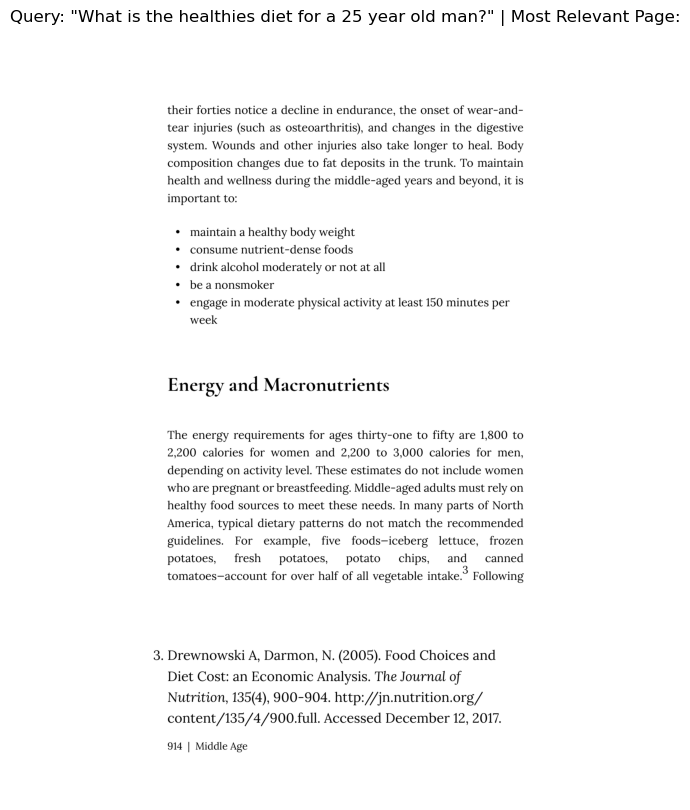

In [49]:
import fitz #pymupdf library

# open PDF and load target
pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(top_1_result_dot_product_page_number+41) # note our page numbers of PDF start at 41

# get the image of the page
img = page.get_pixmap(dpi=300)

# # Save image (optional)
# img.save("output_filename.png")

doc.close()

# convert pixmap to numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))


# Display image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f'Query: "{query}" | Most Relevant Page:')
plt.axis("off")
plt.show()